<a href="https://colab.research.google.com/github/jpastolfo/Seismic-Velocity-Model-Inversion/blob/main/Treinamento(versao2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pré-processamento

In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt


In [ ]:
shot_size = (640,128) #tamanho dos tiros
img_size = (128,128) #tamanho das imagens
n_filters = 12 #número de tiros

In [ ]:
# Chamando os arquivos dos seus diretórios

first_shot_dir ='/content/drive/MyDrive/sismico/data/base/shots/'
first_model_dir ='/content/drive/MyDrive/sismico/data/base/bin/'

second_shot_dir ='/content/drive/MyDrive/sismico/data/new_models/shots/'
second_model_dir ='/content/drive/MyDrive/sismico/data/new_models/bin/'

third_shot_dir = '/content/drive/MyDrive/sismico/data/new_models_shot_variations/shots/'
third_model_dir = '/content/drive/MyDrive/sismico/data/new_models_shot_variations/bin/'

# Carregando caminhos -First
first_shot_list = [xn for xn in os.listdir(first_shot_dir) if "shot" in xn]
first_mask_list = [xn for xn in os.listdir(first_model_dir) if "mod" in xn]
first_mask_list.sort()
first_shot_list.sort()

# Carregando imagens - Train
x_data = np.zeros( (len(first_shot_list), )+img_size+(n_filters, ) ) #train
y_data = np.zeros( (len(first_shot_list), )+img_size) #train

for i in range(len(first_shot_list)):
    ent=np.load(first_shot_dir + first_shot_list[i])
    sai=np.load(first_model_dir + first_mask_list[i])
#    ent.shape
    x_data[i,:,:,:] = np.transpose(ent[ :,:,0:640:5],(2,1,0)) # transposição devido a forma de escrita do deepwave # escolha de subamostrar os tiros a cada 5 amostras
    y_data[i,:,:] = sai[:,:]

#Carregando caminhos - Second

second_shot_list = [xn for xn in os.listdir(second_shot_dir) if "shot" in xn]
second_mask_list = [xn for xn in os.listdir(second_model_dir) if "mod" in xn]
second_mask_list.sort()
second_shot_list.sort()

# Carregando imagens - Test
x_test = np.zeros( (len(second_shot_list), )+img_size+(n_filters, ) ) #test
y_test = np.zeros( (len(second_shot_list), )+img_size) #test

for i in range(len(second_shot_list)):
    ent=np.load(second_shot_dir + second_shot_list[i])
    sai=np.load(second_model_dir + second_mask_list[i])
#    ent.shape
    x_test[i,:,:,:] = np.transpose(ent[ :,:,0:640:5],(2,1,0)) # transposição devido a forma de escrita do deepwave # escolha de subamostrar os tiros a cada 5 amostras
    y_test[i,:,:] = sai[:,:]

In [ ]:
# normalizando x_data e y_data

def normalize_function(img):
    imag = img
    vis_p_max = np.percentile(imag, 96)
    vis_p_min = -np.percentile(imag, 96)
    clip=(vis_p_max - vis_p_min)/2
    imag = np.clip(imag,-clip,clip)
    imag=(imag+clip)/(2*clip)
    return imag

for filt in range(n_filters):
    x_data[:, :, :, filt] = normalize_function(x_data[:, :, :, filt])
y_data=y_data/1000 # trata a velocidade como km/s, range de saída menor
y_data=(y_data-1.5)/2.0

In [ ]:
# normalizando x_test e y_test

for filt in range(n_filters):
    x_test[:, :, :, filt] = normalize_function(x_test[:, :, :, filt])
y_test=y_test/1000 # trata a velocidade como km/s, range de saída menor
y_test=(y_test-1.5)/2.0

In [ ]:
print('x_data (Shots): {} \ny_data (Modelos): {} \n \nx_test (Shots):{} \ny_test(Modelos):{}'.format(x_data.shape, y_data.shape, x_test.shape, x_test.shape))

x_data (Shots): (300, 128, 128, 12) 
y_data (Modelos): (300, 128, 128) 
 
x_test (Shots):(300, 128, 128, 12) 
y_test(Modelos):(300, 128, 128, 12)


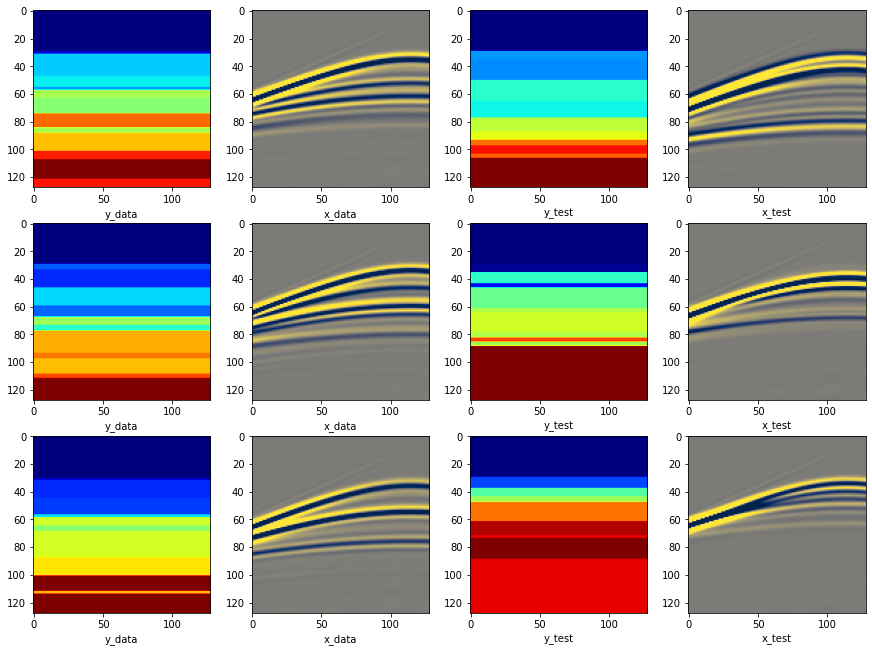

In [ ]:
plt.figure(figsize=(15,15))

for i in range(0,9,4):
     
    plt.subplot(4,4,i+1)
    plt.imshow(y_data[i, :, :],cmap='jet')
    plt.xlabel("y_data")

    plt.subplot(4,4,i+2)
    plt.imshow(x_data[i, :, :, 11], cmap='cividis')
    plt.xlabel("x_data")
    
    plt.subplot(4,4,i+3)
    plt.imshow(y_test[i, :, :],cmap='jet')
    plt.xlabel("y_test")

    plt.subplot(4,4,i+4)
    plt.imshow(x_test[i, :, :, 11],cmap='cividis')
    plt.xlabel("x_test")

# Treinamento da U_net (normal) 
### testando os nossos dados sem finalidade de refletir os reais objetivos

In [ ]:
!ls /content/drive/MyDrive/notebook/*py
import sys
sys.path.append('/content/drive/MyDrive/notebook/')

/content/drive/MyDrive/notebook/modelos.py


In [ ]:
from modelos import get_unet, get_unet_mod, ssim_loss, ssim_loss_rsme, Input, Adam, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, tf

In [ ]:
input_img = Input((128, 128, n_filters), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, moment=0.2 ,batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0002), loss=tf.keras.losses.MeanSquaredError(), metrics=["mean_absolute_error"]) #zera os pesos

In [ ]:
#divisão de conjuntos de teste treino e validação e parâmetros gerais da rede
#from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(x_data, np.expand_dims(y_data, axis=-1), test_size=0.2, random_state=666)


In [ ]:
## Call Backs
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0001)
]

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, np.expand_dims(y_data, axis=-1), 
                                                    test_size=0.2, random_state=666)
BATCH = 8
EPOCAS = 100

loss = np.zeros((EPOCAS))
val_loss =np.zeros((EPOCAS))
accuracy =np.zeros((EPOCAS))
val_accuracy = np.zeros((EPOCAS))
ims= []

results = model.fit(x_train, y_train, batch_size=BATCH, epochs=EPOCAS, callbacks=callbacks, validation_data=(x_val, y_val))

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.4091 - mean_absolute_error: 0.4827
Epoch 1: val_loss improved from inf to 0.37370, saving model to model_teste01.h5
30/30 [==============================] - 13s 97ms/step - loss: 0.4091 - mean_absolute_error: 0.4827 - val_loss: 0.3737 - val_mean_absolute_error: 0.5204 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.2027 - mean_absolute_error: 0.3341
Epoch 2: val_loss improved from 0.37370 to 0.27447, saving model to model_teste01.h5
30/30 [==============================] - 2s 71ms/step - loss: 0.2027 - mean_absolute_error: 0.3341 - val_loss: 0.2745 - val_mean_absolute_error: 0.4335 - lr: 1.0000e-04
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.1292 - mean_absolute_error: 0.2648
Epoch 3: val_loss improved from 0.27447 to 0.19740, saving model to model_teste01.h5
30/30 [==============================] - 2s 68ms/step - loss: 0.1292 - mean_absolute_error: 

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('/content/drive/MyDrive/sismico/modelos')

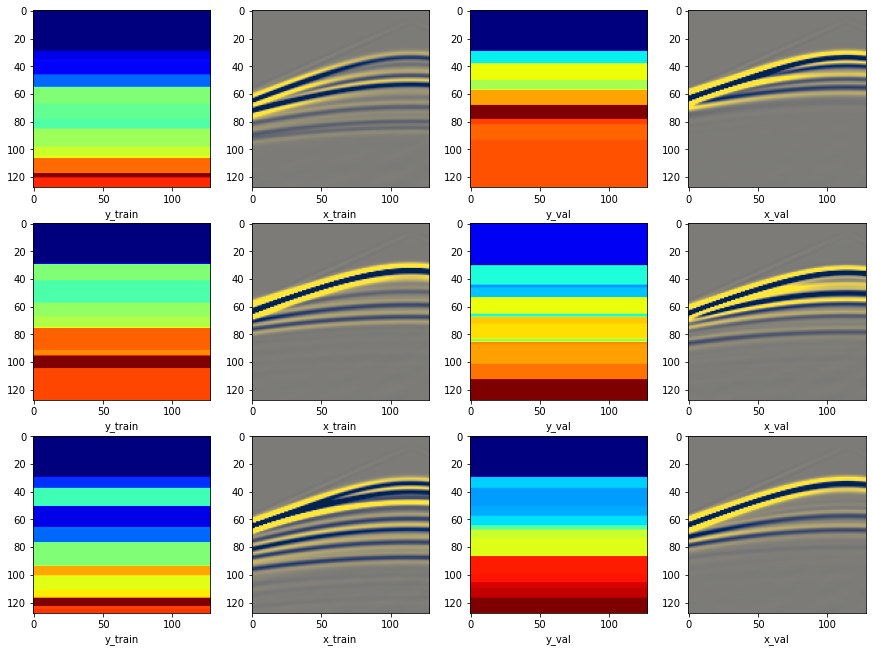

In [ ]:
plt.figure(figsize=(15,15))

for i in range(0,9,4):
     
    plt.subplot(4,4,i+1)
    plt.imshow(np.squeeze(y_train[i, :, :]),cmap='jet')
    plt.xlabel("y_train")

    plt.subplot(4,4,i+2)
    plt.imshow(x_train[i, :, :, 11], cmap='cividis')
    plt.xlabel("x_train")
    
    plt.subplot(4,4,i+3)
    plt.imshow(np.squeeze(y_val[i, :, :]),cmap='jet')
    plt.xlabel("y_val")

    plt.subplot(4,4,i+4)
    plt.imshow(x_val[i, :, :, 11],cmap='cividis')
    plt.xlabel("x_val")

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(results.history) 

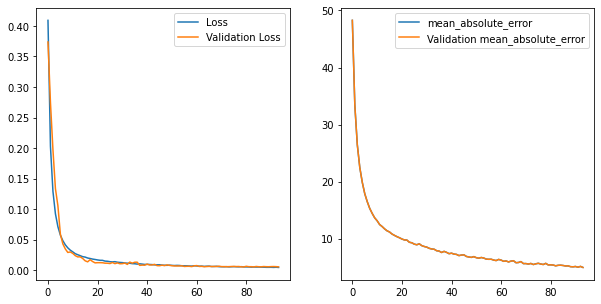

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(results.history['loss'], '-', label = 'Loss')
ax1.plot(results.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(results.history['mean_absolute_error']), '-', 
         label = 'mean_absolute_error')
ax2.plot(100*np.array(results.history['mean_absolute_error']), '-',
         label = 'Validation mean_absolute_error')
ax2.legend()

In [ ]:
#Nesse ponto, usaremos dados novos para fazer o teste na rede!!
preds = model.predict(x_test)

10/10 [==============================] - 2s 101ms/step


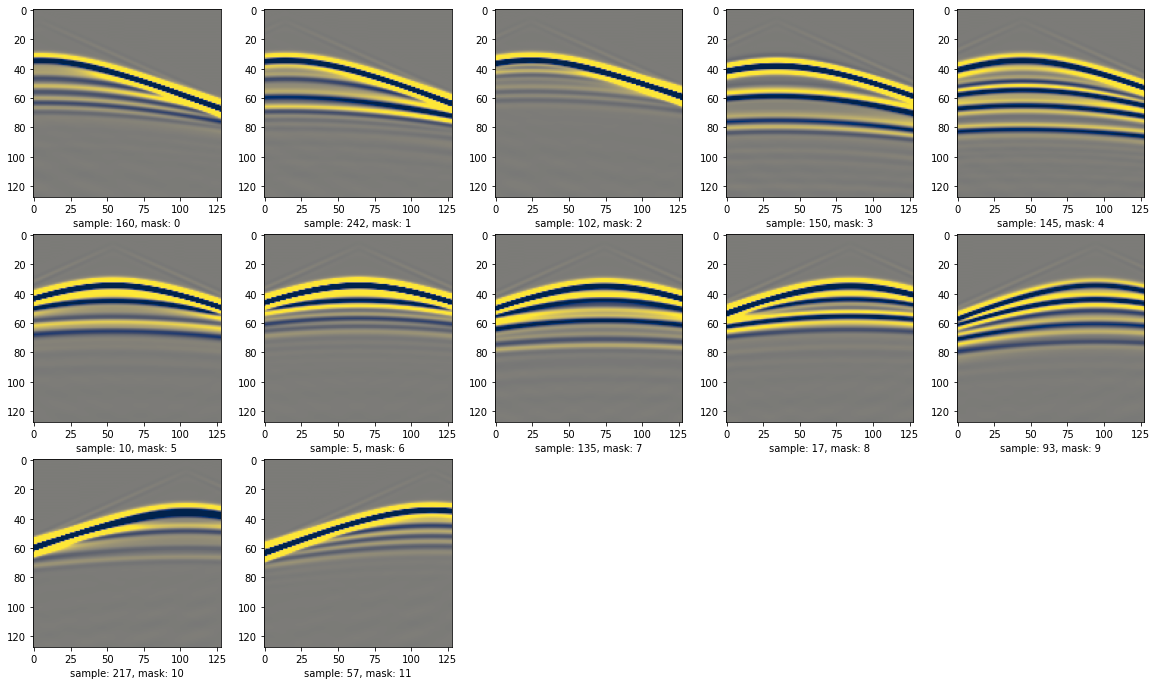

In [ ]:
plt.figure(figsize=(20,20))

import random

for i in range(12):

  r = random.randint(0, 256)

  plt.subplot(5,5,i+1)
  plt.imshow(x_test[r, :, :, i], cmap='cividis')
  plt.xlabel(f"sample: {r}, mask: {i}")

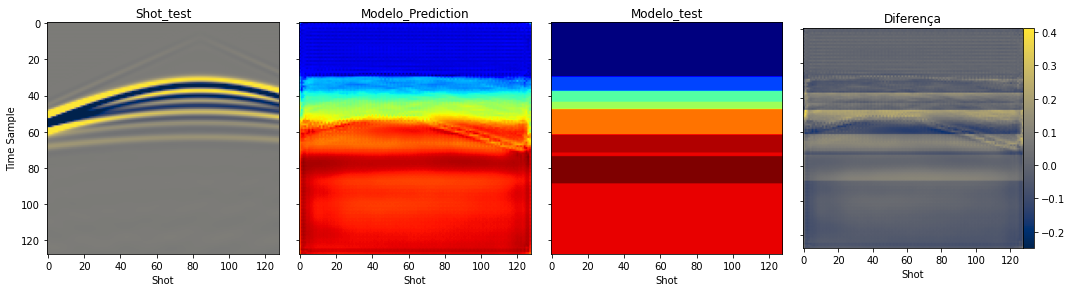

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax_shot, ax_prediction, ax_model, ax_diff) = plt.subplots(1, 4, figsize=(15, 15), sharey=True)

# ax_shot = fig.add_subplot(1, 4, 1)
# ax_prediction = fig.add_subplot(1, 4, 2)
# ax_model = fig.add_subplot(1, 4, 3)
# ax_diff = fig.add_subplot(1, 4, 4)

for i in range(0,9,4):
  

    ax_shot.imshow(x_test[i, :, :,i],cmap='cividis')
    ax_shot.set_title("Shot_test")

    ax_prediction.imshow(np.squeeze(preds[i, :, :]), cmap='jet')
    ax_prediction.set_title("Modelo_Prediction")

    ax_model.imshow(y_test[i, :, :], cmap='jet')
    ax_model.set_title("Modelo_test")
    
    oi = ax_diff.imshow(y_test[i, :, :] - np.squeeze(preds[i, :, :]), cmap='cividis')
    ax_diff.set_title("Diferença")

divider = make_axes_locatable(ax_diff)
diff_colorbar = divider.append_axes("right", size="5%", pad=0.00)
fig = ax_diff.get_figure()
fig.add_axes(ax_diff)

plt.colorbar(oi, cax=diff_colorbar)
diff_colorbar.yaxis.tick_right()
diff_colorbar.yaxis.set_tick_params(labelright=True)

ax_shot.set_ylabel("Time Sample")

for ax in (ax_prediction, ax_model, ax_diff):
  ax.set_xlabel("")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/sismico/Imagens/comparacao_train.png',dpi=300)

### Coeficiente Sørensen–Dice 
#### Calcular o índice de similaridade entre as minhas amostras. Nesse caso, a intersecção entre as variáveis teste e preditada
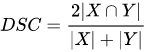

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

print('Coeficiente Sørensen–Dice é {:.2f}%.'.format(100*(dice_coef(y_test, preds))))

Coeficiente Sørensen–Dice é 74.44%.


# Treinamento dos dados - GridSearch CV

In [ ]:
##GridSearch CV
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

X_train

results = model.fit(x_train, y_train, batch_size=BATCH, epochs=EPOCAS, callbacks=callbacks, validation_data=(x_val, y_val))